# Machine Learning Evaluation

Evaluating a machine learning model is a critical step to ensure its performance and reliability in making predictions or classifications. The evaluation process helps you understand how well your model generalizes to unseen data and whether it's meeting the desired objectives.

In [ ]:
# download the data
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [1]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, mutual_info_score, mean_squared_error, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer

## Prepare the data and Exploratory Data Analysis (EDA):

We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

- Make,
- Model,
- Year,
- Engine HP,
- Engine Cylinders,
- Transmission Type,
- Vehicle Style,
- highway MPG,
- city mpg
- MSRP

In [2]:
features = [
    'Make', 'Model','Year','Engine HP','Engine Cylinders','Transmission Type',
    'Vehicle Style','highway MPG','city mpg','MSRP'
]

df = pd.read_csv('../data/data.csv', iterator=False, usecols=features)
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


### Data Preparation

In [3]:
# transform the column names to lower case and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

# fill the missing values with 0
df.fillna(0, inplace=True)

# rename msrp to price
df.rename(columns={'msrp': 'price'}, inplace=True)

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


#### Make price binary

In [4]:
# make the price column binary getting the price median value and then adding a new column above_average = 1 when price > median and 0 otherwise
price_median = df['price'].median()
df['above_average'] = (df['price'] > price_median).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,1
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,1


#### Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value (price) is not in your dataframe.

In [30]:
# split the data in train/val/test sets, with 60%/20%/20% distribution with seed 1
# .2 splits the data into 80% train and 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#.25 splits the 80% train into 60% train and 20% val
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset the indexes of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# separate the target variable from the train/val/test sets
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
y_train_binary = df_train.above_average.values
y_val_binary = df_val.above_average.values
y_test_binary = df_test.above_average.values

# delete the price column from the train/val/test sets
del df_train['price']
del df_val['price']
del df_test['price']

print('train data length: ',len(df_train),'price values length: ', len(y_train))


train data length:  7148 price values length:  7148


### Question 1: ROC AUC feature importance

ROC AUC (Area Under the Curve) could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [6]:
# define the numerical features
numerical_features = [
    'year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg'
]   

# get the categorical features
categorical_features = [
    'make', 'model', 'transmission_type', 'vehicle_style'
]

all_features = numerical_features + categorical_features

In [32]:
# for each numerical feature, use it as score and compute AUC with the above_average variable
auc_scores = {}
for feature in numerical_features:

     # Compute AUC for the current numerical feature
    auc = roc_auc_score(y_train_binary, df_train[feature])    
    auc_scores[feature] = auc
    print(feature, auc)

# get the value and label of the max auc score
max_auc = max(auc_scores.values())
max_auc_label = max(auc_scores, key=auc_scores.get)
print(f'max auc score: { max_auc_label} with {max_auc}')


year 0.7355219698158973
engine_hp 0.9185032753403845
engine_cylinders 0.7359391338287677
highway_mpg 0.377306802286729
city_mpg 0.34417514781409736
max auc score: engine_hp with 0.9185032753403845


### Question 2 - Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [34]:
# to the train data apply the OneHotEncoder using DictVectorizer
# fit_transform() fits the data and then transforms it

dv = DictVectorizer(sparse=False)

train_dict = df_train[all_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# train the logistic regression model with these parameters: 
# solver='liblinear', C=1.0, max_iter=1000
# fit() fits the model according to the given training data
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train_binary)


LogisticRegression(max_iter=1000, solver='liblinear')

In [43]:
# what is the AUC of this model on the validation dataset? (round to 3 digits)
val_dict = df_val[all_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
# The [:, 1] notation selects the second column of the result, which contains the probabilities for the positive class.
y_pred = model.predict_proba(X_val)[:, 1]
print(f'Prd: {y_pred}  \n\nActual : {y_val}')
# get the auc score using the above_average variable (binary)
auc = round(roc_auc_score(y_val_binary, y_pred), 3)
print(f'AUC score: {auc}')


Prd: [0.94602701 0.05654883 0.98308002 ... 0.01110863 0.99999984 0.84289636]  

Actual : [ 43290   6175  36495 ...  23249 102100  26710]
AUC score: 0.982


### Question 3 - Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.28
- 0.48
- 0.68

Precision: 0.9292845257903494 Recall: 0.9285120532003325 Threshold: 0.48


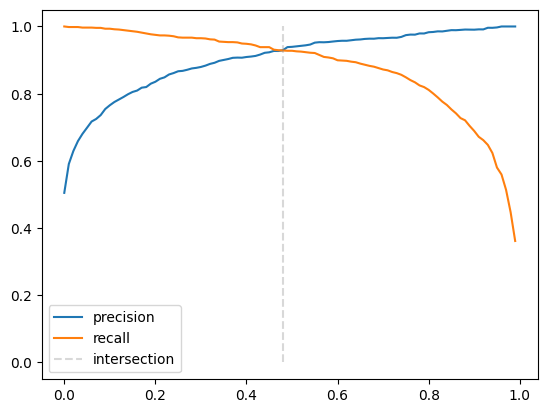

In [58]:
# Calculate precision and recall for various thresholds from 0.0 to 1.0 `.0 with step 0.01`
precisions = []
recalls = []
thresholds = np.arange(0, 1, 0.01)
actual_positive = (y_val_binary == 1)
actual_negative = (y_val_binary == 0)

for t in thresholds:    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)


# get the precision and recall values at which they intersect
intersect = 0.5
for i in range(len(thresholds)):
    if round(precisions[i],3) == round(recalls[i],3):
        print(f'Precision: {precisions[i]} Recall: {recalls[i]} Threshold: {thresholds[i]}')
        intersect = thresholds[i]
        break

# Plot the precision-recall curve
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
# label the intersection of the curves
plt.plot([intersect, intersect], [0, 1], linestyle='--', color='grey', label='intersection', alpha=0.3)
plt.legend()
plt.show()
